# コード5-1：MCMCを用いたベイズ推定の実装

『ウイルス感染の数理モデルとシミュレーション ーデータを定量的に理解するー』

MCMCを用いたベイズ推定の実装の例をまとめる。

## ライブラリ、パッケージ（モジュール）の読み込み

In [4]:
## 必要があればインストール
## !pip3 install matplotlib numpy pystan nest_asyncio
## for pystan, check https://httpstan.readthedocs.io/en/latest/installation.html for unsupported platform

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import random
import pandas as pd

## pystan
import stan
import nest_asyncio
nest_asyncio.apply()

## MCMCを用いたベイズ推定

式(3.3)

$$
F_{A,co}=\frac{1}{\left(1+\frac{\beta}{q} V ̅_{\text{GFP}} \right)^p} -\frac{1}{\left(1 + \frac{\beta}{q} \left(V ̅_{\text{GFP}}+V ̅_{\text{HSA}} \right) \right)^p} , \\
F_{B,co} = 1 - \frac{1}{\left(1 + \frac{\beta}{q} V ̅_{\text{HSA}} \right)^p} - \frac{1}{\left(1+ \frac{\beta}{q} V ̅_{\text{GFP}} \right)^p} + \frac{1}{\left(1+\frac{\beta}{q} \left(V ̅_{\text{GFP}}+V ̅_{\text{HSA}} \right)\right)^p}, \\
F_{C,co} = \frac{1}{\left(1+\frac{\beta}{q} \left(V ̅_{\text{GFP}} + V ̅_{\text{HSA}} \right)\right)^p} , \\
F_{D,co} = \frac{1}{\left(1 + \frac{\beta}{q} V ̅_{\text{HSA}} \right)^p} -\frac{1}{\left(1+\frac{\beta}{q} \left(V ̅_{\text{GFP}}+V ̅_{\text{HSA}} \right)\right)^p} .)
$$

において、各区画の割合が得られたときに、パラメータ$p, \frac{\beta}{q} V_{\text{HSA}}, \frac{\beta}{q} V_{\text{GFP}}, j_{6.25}, , j_{12.5}, j_{25}, j_{37}, j_{50}, j_{75}, j_{100}, j_{200}$を推定する。

pystanパッケージを用いて行う

参考：

- Remion et al. Virology 2016  
https://doi.org/10.1016/j.virol.2015.09.028
- Ito et al. Sci Rep 2017  
https://doi.org/10.1038/s41598-017-03954-9
- Ito et al. J Theor Biol 2018

In [41]:
## p, beta*V_HSA/q, beta*V_GFP/q, j_6.25, j_12.5, j_25, j_37, j_50, j_75, j_100, j_200
pars = np.array([1.176, #p
                 1.484*np.power(10.0, -2.0), #beta*V_HSA/q
                 2.115*np.power(10.0, -2.0), #beta*V_GFP/q
                 2.417, #j_6.25
                 4.231, #j_12.5
                 4.352, #j_25
                 11.09, #j_37
                 8.115, #j_50
                 12.79, #j_75
                 16.75, #j_100
                 26.87]) #j_200

In [42]:
## 式(3.3)
def model_coinfection(c_hsa, c_gfp, parms):
    
    p = parms[0]
    beta_vhsa_q = parms[1]
    beta_vgfp_q = parms[2]
    j625 = parms[3]
    j125 = parms[4]
    j25 = parms[5]
    j37 = parms[6]
    j50 = parms[7]
    j75 = parms[8]
    j100 = parms[9]
    j200 = parms[10]
    
    j_scale_hsa = scale_par(c_hsa, parms[3:11])
    j_scale_gfp = scale_par(c_gfp, parms[3:11])
    
    #print(j_scale_hsa, j_scale_gfp)
    
    f_a_co = 0.0; f_b_co = 0.0; f_c_co = 100.0; f_d_co = 0.0
    
    f_hsa = 1.0/np.power((1.0 + beta_vhsa_q*j_scale_hsa), p)
    f_gfp = 1.0/np.power((1.0 + beta_vgfp_q*j_scale_gfp), p)
    f_hsagfp = 1.0/np.power((1.0 + beta_vhsa_q*j_scale_hsa + beta_vgfp_q*j_scale_gfp), p)
    
    if c_hsa > 0 and c_gfp > 0:
        f_a_co = f_gfp - f_hsagfp
        f_b_co = 1 - f_gfp - f_hsa + f_hsagfp
        f_c_co = f_hsagfp
        f_d_co = f_hsa - f_hsagfp
    elif c_hsa > 0:
        f_a_co = 1 - f_hsa
        f_b_co = 0.0
        f_c_co = f_hsa
        f_d_co = 0.0
    elif c_gfp > 0:
        f_a_co = 0.0
        f_b_co = 0.0
        f_c_co = f_gfp
        f_d_co = 1 - f_gfp
    else:
        print('"At least one viral dose must be greater than 0."')
        return "At least one viral dose must be greater than 0."
     
    
    return [100.0*f_a_co, 100.0*f_b_co, 100.0*f_c_co, 100.0*f_d_co]

def scale_par(effective_virus, scales):
    if effective_virus == 3.12:
        return 1.0
    elif effective_virus == 6.25:
        return scales[0]
    elif effective_virus == 12.5:
        return scales[1]
    elif effective_virus == 25:
        return scales[2]
    elif effective_virus == 37:
        return scales[3]
    elif effective_virus == 50:
        return scales[4]
    elif effective_virus == 75:
        return scales[5]
    elif effective_virus == 100:
        return scales[6]
    elif effective_virus == 200:
        return scales[7]
    elif effective_virus == 0.0:
        return 0.0
    else:
        print('error: "Invalid dose"')
        return "Invalid dose"

In [44]:
## ノイズを加えてデータを生成

random.seed(1234)

dose_hsa_single = [3.12, 6.25, 12.5, 25, 37, 50, 75, 100, 100, 200]
dose_gfp_single = [3.12, 6.25, 12.5, 25, 50, 50, 75, 100, 100, 200]

dose_hsa_co1 = [25, 50, 100]
dose_hsa_co2 = [37, 75, 100]
dose_gfp_co1 = [25, 50, 100]
dose_gfp_co2 = [50, 75, 100]

dose_hsa = dose_hsa_single + [0]*len(dose_gfp_single) + \
           [x for x in dose_hsa_co1 for i in range(len(dose_gfp_co1))] + \
           [x for x in dose_hsa_co2 for i in range(len(dose_gfp_co2))]
dose_gfp = [0]*len(dose_hsa_single) + dose_gfp_single + \
           dose_gfp_co1*len(dose_hsa_co1) + \
           dose_gfp_co2*len(dose_hsa_co2)

dose_exp = np.vstack([np.array(dose_hsa), np.array(dose_gfp)])

for i in range(dose_exp.shape[1]):
    freq_true = model_coinfection(dose_exp[:,i][0], dose_exp[:,i][1], pars)
    freq_gen = np.array(model_coinfection(dose_exp[:,i][0], dose_exp[:,i][1], pars))*np.array(np.random.uniform(0.6, 1.4, 4))
    freq_gen = 100*freq_gen/freq_gen.sum()
    #print("f:", freq_gen)
    if i == 0:
        data_true = freq_true
        data_gen = freq_gen
    else:
        data_true = np.vstack([data_true, freq_true])
        data_gen = np.vstack([data_gen, freq_gen])

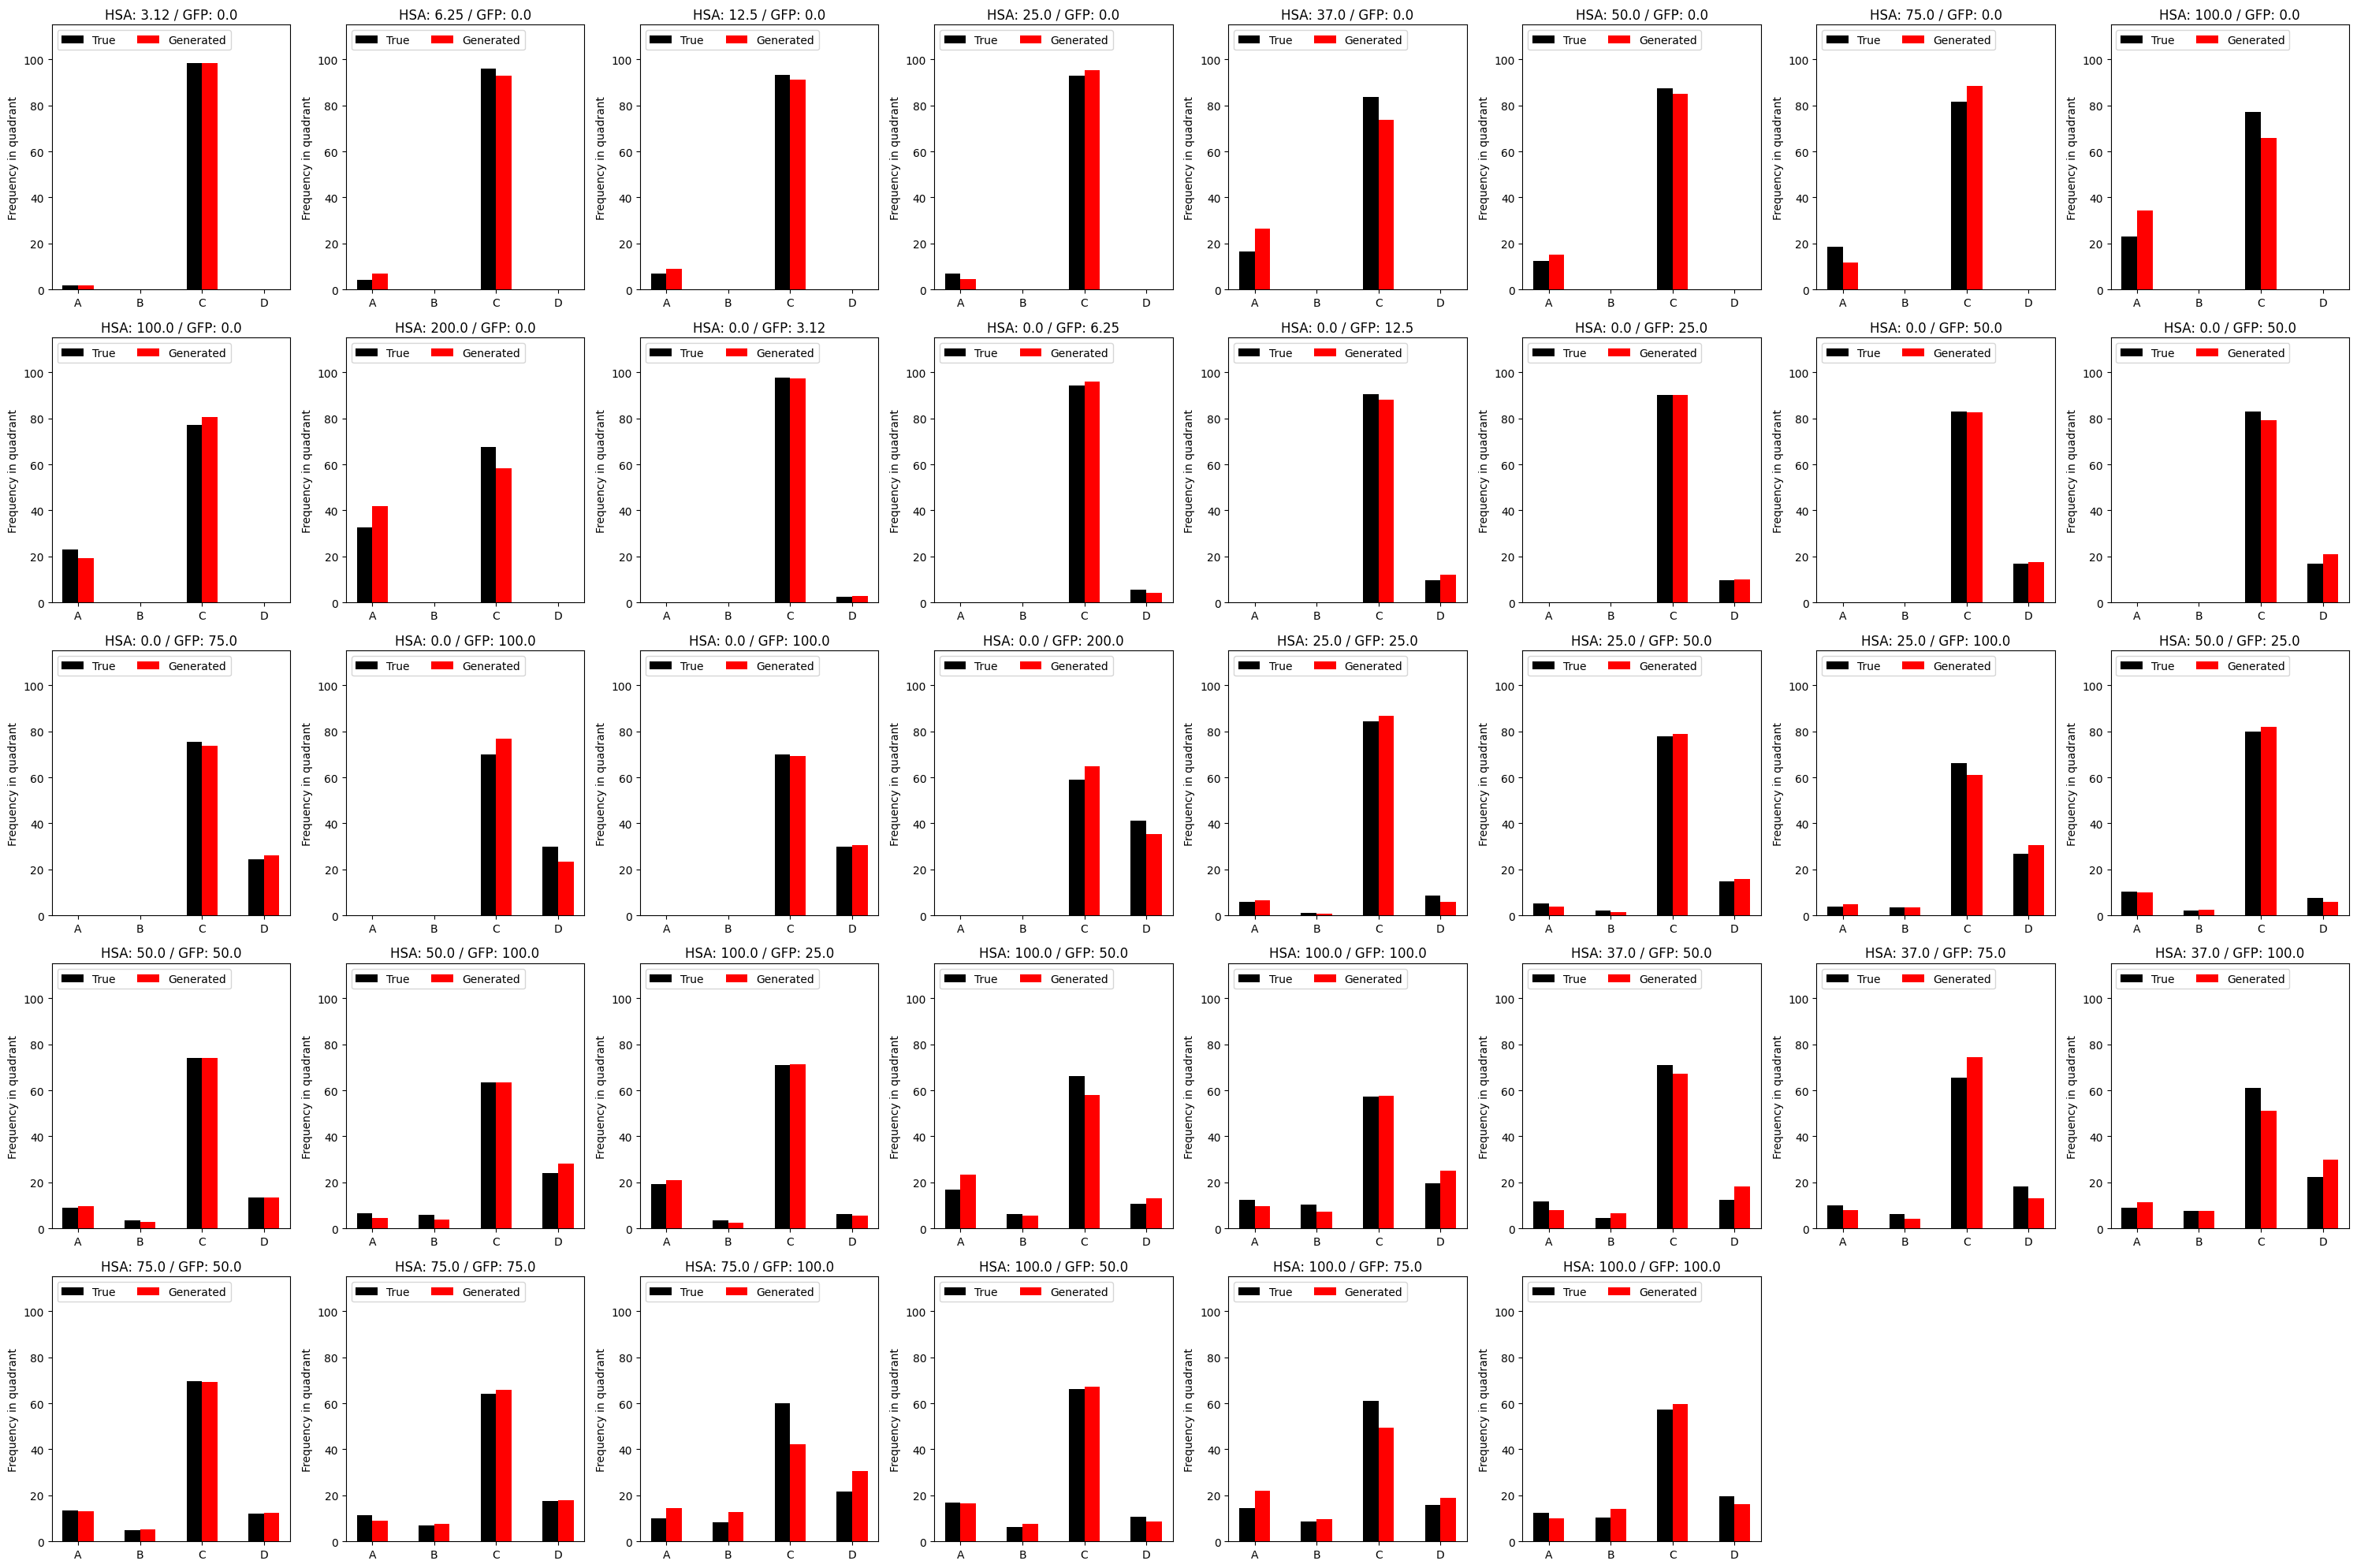

In [45]:
## データのプロット

fig = plt.figure(figsize = (30, 20))

for i in range(data_gen.shape[0]):
    ax = fig.add_subplot(5, 8, i+1)

    x = np.arange(data_gen.shape[1])
    width = 0.25

    offset = 0
    ax.bar(x + offset, data_true[i,], width, label = "True", color = "black")
    offset = width
    ax.bar(x + offset, data_gen[i,], width, label = "Generated", color = "red")

    ax.set_ylabel('Frequency in quadrant')
    ax.set_title("HSA: " + str(dose_exp[:,i][0]) + " / " + "GFP: " + str(dose_exp[:,i][1]))
    ax.set_xticks((x + x + width*(2 - 1))/2, ["A", "B", "C", "D"])
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 115)

fig.tight_layout()
plt.show()


In [46]:
model_stan_coinfection = """
functions {
  
  real scale_par(int effective_virus, array[] real scales) {
    if (effective_virus == 1) {
        return 1.0;
    } else if (effective_virus > 1 && effective_virus < 10) {
        return scales[effective_virus + 2];
    }  else if (effective_virus == 0) {
        return 0.0;
    } else {
        return 1000000.0;
    }
  }
  array[] real model_coinfection(int c_hsa, int c_gfp, array[] real parms, int expt_type) {
    real p = parms[1];
    real beta_vhsa_q = parms[2];
    real beta_vgfp_q = parms[3];
    
    real j_scale_hsa = scale_par(c_hsa, parms);
    real j_scale_gfp = scale_par(c_gfp, parms);
    
    real f_a_co = 0.0; real f_b_co = 0.0; real f_c_co = 100.0; real f_d_co = 0.0;
    
    real f_hsa = 1.0/pow((1.0 + beta_vhsa_q*j_scale_hsa), p);
    real f_gfp = 1.0/pow((1.0 + beta_vgfp_q*j_scale_gfp), p);
    real f_hsagfp = 1.0/pow((1.0 + beta_vhsa_q*j_scale_hsa + beta_vgfp_q*j_scale_gfp), p);
    
    if (c_hsa > 0 && c_gfp > 0) {
        f_a_co = f_gfp - f_hsagfp;
        f_b_co = 1.0 - f_gfp - f_hsa + f_hsagfp;
        f_c_co = f_hsagfp;
        f_d_co = f_hsa - f_hsagfp;
    } else if (c_hsa > 0) {
        f_a_co = 1.0 - f_hsa;
        f_b_co = 0.0;
        f_c_co = f_hsa;
        f_d_co = 0.0;
    } else if (c_gfp > 0) {
        f_a_co = 0.0;
        f_b_co = 0.0;
        f_c_co = f_gfp;
        f_d_co = 1.0 - f_gfp;
    } else {
    
    }
    
    if (expt_type == 1) {
      return {100.0*f_a_co, 100.0*f_c_co};
    } else if (expt_type == 2) {
      return {100.0*f_c_co, 100.0*f_d_co};
    } else {
      return {100.0*f_a_co, 100.0*f_b_co, 100.0*f_c_co, 100.0*f_d_co};
    }
    
  }
  
  
}
data {
  int<lower=0> num_expt_HSA_single;         // number of experiments
  int<lower=0> num_expt_GFP_single;         // number of experiments
  int<lower=0> num_expt_co;         // number of experiments
  int<lower=0> num_quad_HSA_single;      // number of quadorants
  int<lower=0> num_quad_GFP_single;      // number of quadorants
  int<lower=0> num_quad_co;      // number of quadorants
  array[num_expt_HSA_single, num_quad_HSA_single] real freqs_HSA_single;   // frequency
  array[num_expt_GFP_single, num_quad_GFP_single] real freqs_GFP_single;   // frequency
  array[num_expt_co, num_quad_co] real freqs_co;   // frequency
  array[num_expt_HSA_single, 2] int conc_HSA_single;  //effective virus titier, HSA, GFP
  array[num_expt_GFP_single, 2] int conc_GFP_single;  //effective virus titier, HSA, GFP
  array[num_expt_co, 2] int conc_co;  //effective virus titier, HSA, GFP
}
parameters {
  // model parameters
  real<lower=log(0.01), upper=log(100.0)> p;
  real<lower=log(0.0001), upper=log(1.0)> beta_vhsa_q;
  real<lower=log(0.0001), upper=log(1.0)> beta_vgfp_q;
  real<lower=log(0.01), upper=log(100.0)> j625;
  real<lower=log(0.01), upper=log(100.0)> j125;
  real<lower=log(0.01), upper=log(100.0)> j25;
  real<lower=log(0.01), upper=log(100.0)> j37;
  real<lower=log(0.01), upper=log(100.0)> j50;
  real<lower=log(0.01), upper=log(100.0)> j75;
  real<lower=log(0.01), upper=log(100.0)> j100;
  real<lower=log(0.01), upper=log(100.0)> j200;
  
  // standard deviation of error model
  real<lower=0, upper=1000.0> sigma;
}
transformed parameters{
  array[num_expt_HSA_single, num_quad_HSA_single] real y_HSA_single;
  array[num_expt_GFP_single, num_quad_GFP_single] real y_GFP_single;
  array[num_expt_co, num_quad_co] real y_co;
  {
    array[11] real parms;
    parms[1] = exp(p); parms[2] = exp(beta_vhsa_q); parms[3] = exp(beta_vgfp_q);
    parms[4] = exp(j625); parms[5] = exp(j125); parms[6] = exp(j25); parms[7] = exp(j37);
    parms[8] = exp(j50); parms[9] = exp(j75); parms[10] = exp(j100); parms[11] = exp(j200);
    
    // HSA single
    for (i in 1:num_expt_HSA_single) {
      y_HSA_single[i,] = model_coinfection(conc_HSA_single[i, 1], conc_HSA_single[i, 2], parms, 1);
    }
    // GFP single
    for (i in 1:num_expt_GFP_single) {
      y_GFP_single[i,] = model_coinfection(conc_GFP_single[i, 1], conc_GFP_single[i, 2], parms, 2);
    }
    // coinfection
    for (i in 1:num_expt_co) {
      y_co[i,] = model_coinfection(conc_co[i, 1], conc_co[i, 2], parms, 3);
    }
    
  }
}
model {
  // priors
  p ~ uniform(log(0.01), log(100.0)); //1.176
  beta_vhsa_q ~ uniform(log(0.0001), log(1.0)); //1.484*np.power(10.0, -2.0)
  beta_vgfp_q ~ uniform(log(0.0001), log(1.0)); //2.115*np.power(10.0, -2.0)
  j625 ~ uniform(log(0.01), log(100.0)); //2.417
  j125 ~ uniform(log(0.01), log(100.0)); //4.231
  j25 ~ uniform(log(0.01), log(100.0)); //4.352
  j37 ~ uniform(log(0.01), log(100.0)); //11.09
  j50 ~ uniform(log(0.01), log(100.0)); //8.115
  j75 ~ uniform(log(0.01), log(100.0)); //12.79
  j100 ~ uniform(log(0.01), log(100.0)); //16.75
  j200 ~ uniform(log(0.01), log(100.0)); //26.87
  
  // HSA single
  for (i in 1:num_expt_HSA_single) {
    for (j in 1:num_quad_HSA_single) {
      freqs_HSA_single[i, j] ~ lognormal(log(y_HSA_single[i, j]), sigma);
    }
  }
  // GFP signle
  for (i in 1:num_expt_GFP_single) {
    for (j in 1:num_quad_GFP_single) {
      freqs_GFP_single[i, j] ~ lognormal(log(y_GFP_single[i, j]), sigma);
    }
  }
  // coinfection
  for (i in 1:num_expt_co) {
    for (j in 1:num_quad_co) {
      freqs_co[i, j] ~ lognormal(log(y_co[i, j]), sigma);
    }
  }
  sigma ~ cauchy(1,5);
}
"""

In [47]:
freqs_HSA_single = data_gen[0:10, [0, 2]]
freqs_GFP_single = data_gen[10:20, [2, 3]]
freqs_co = data_gen[20:38, ]
## 0: 0, 1: 3.12, 2: 6.25, 3: 12.5, 4: 25, 5: 37, 6: 50, 7: 75, 8: 100, 9: 200
d_hsa_single = [1, 2, 3, 4, 5, 6, 7, 8, 8, 9]
d_gfp_single = [1, 2, 3, 4, 6, 6, 7, 8, 8, 9]
d_hsa_co1 = [4, 6, 8]
d_hsa_co2 = [5, 7, 8]
d_gfp_co1 = [4, 6, 8]
d_gfp_co2 = [6, 7, 8]

conc_HSA_single = np.array([d_hsa_single, [0]*len(d_hsa_single)]).T
conc_GFP_single = np.array([[0]*len(d_gfp_single), d_gfp_single]).T
conc_co = np.array([[x for x in d_hsa_co1 for i in range(len(d_gfp_co1))] + \
                    [x for x in d_hsa_co2 for i in range(len(d_gfp_co2))], \
                    d_gfp_co1*len(d_hsa_co1) + \
                    d_gfp_co2*len(d_hsa_co2)]).T

data_stan = {"num_expt_HSA_single": 10,
             "num_expt_GFP_single": 10,
             "num_expt_co": 18,
             "num_quad_HSA_single": 2,
             "num_quad_GFP_single": 2,
             "num_quad_co": 4,
             "freqs_HSA_single": freqs_HSA_single,
             "freqs_GFP_single": freqs_GFP_single,
             "freqs_co": freqs_co,
             "conc_HSA_single": conc_HSA_single,
             "conc_GFP_single": conc_GFP_single,
             "conc_co": conc_co}

In [48]:
posterior = stan.build(model_stan_coinfection, data=data_stan, random_seed=1)

Building...



Building: found in cache, done.Messages from stanc:
    in its declaration. These hard constraints are not recommended, for two
    reasons: (a) Except when there are logical or physical constraints, it is
    very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.


In [49]:
num_sample = 10000

fit = posterior.sample(num_chains=4, num_samples=num_sample, num_warmup = 1000)

Sampling:   0%
Sampling:   0% (100/44000)
Sampling:   0% (200/44000)
Sampling:   1% (400/44000)
Sampling:   1% (600/44000)
Sampling:   2% (900/44000)
Sampling:   3% (1300/44000)
Sampling:   4% (1700/44000)
Sampling:   5% (2100/44000)
Sampling:   6% (2500/44000)
Sampling:  30% (13000/44000)
Sampling:  53% (23400/44000)
Sampling:  77% (33800/44000)
Sampling: 100% (44000/44000)
Sampling: 100% (44000/44000), done.
Messages received during sampling:
  Gradient evaluation took 8.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Scale parameter is 0, but must be positive finite! (in '/tmp/httpstan_2yg2qeva/model_b5ahfckr.stan', line 133, column 6 to column 73)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices

In [50]:
df_fit = fit.to_frame()

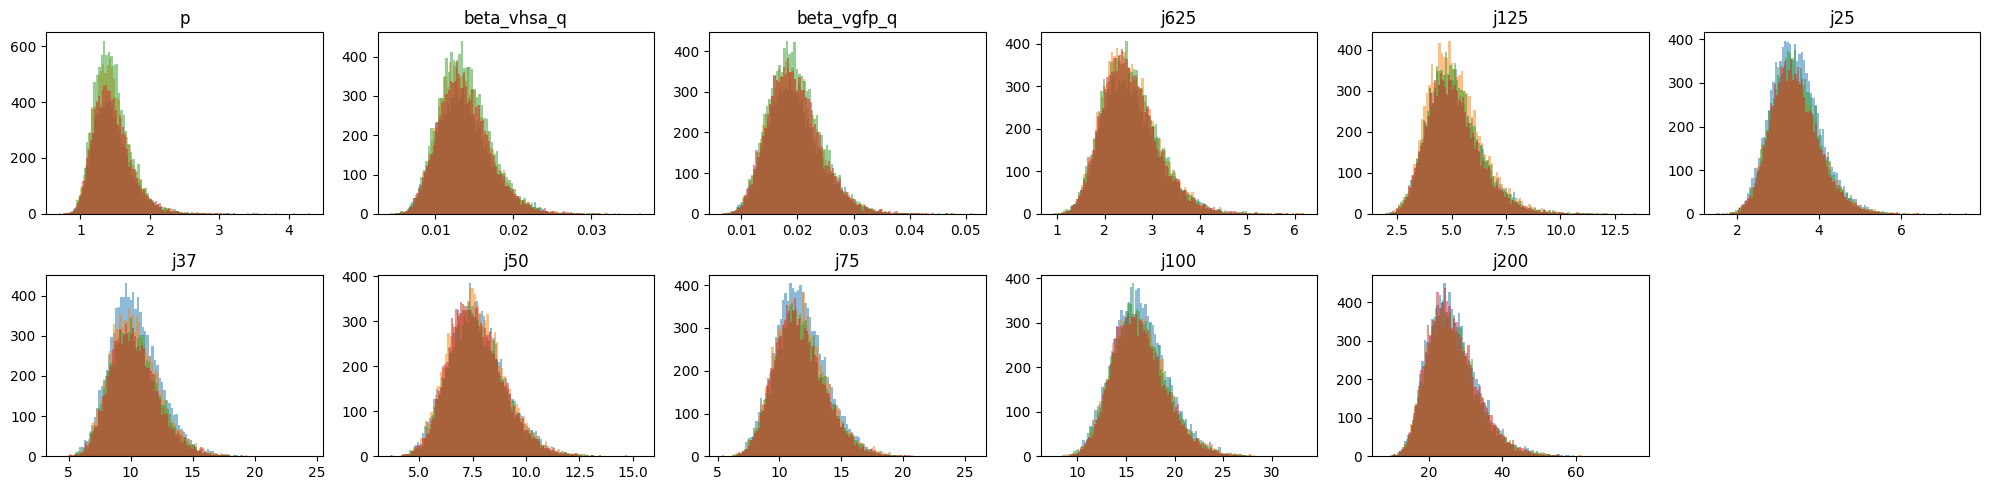

In [51]:
fig = plt.figure(figsize = (20, 5))

for i in range(11):
    ax = fig.add_subplot(2, 6, i + 1)
    for j in range(4):
        ax.hist(np.exp(df_fit[fit.param_names[i]][(j*num_sample):(j+1)*num_sample]), bins = 100, alpha = 0.5)
        ax.set_title(fit.param_names[i])
    
fig.tight_layout()
plt.show()

In [52]:
mean_HSA_single = []
mean_GFP_single = []
mean_co = []
ci_HSA_single = []
ci_GFP_single = []
ci_co = []

mean_all = df_fit.mean(axis='rows')
ci_low_all = mean_all - df_fit.quantile(q=0.025)
ci_up_all = df_fit.quantile(q=0.975) - mean_all

for i in range(10):
    mean_HSA_single.append([mean_all[i+19], mean_all[i+29]])
    mean_GFP_single.append([mean_all[i+39], mean_all[i+49]])
    ci_HSA_single.append([[ci_low_all[i+19], ci_low_all[i+29]], [ci_up_all[i+19], ci_up_all[i+29]]])
    ci_GFP_single.append([[ci_low_all[i+39], ci_low_all[i+49]], [ci_up_all[i+39], ci_up_all[i+49]]])

for i in range(18):
    mean_temp = []
    ci_low_temp = []
    ci_up_temp = []
    for j in range(4):
        mean_temp.append(mean_all[i+59+j*18])
        ci_low_temp.append(ci_low_all[i+59+j*18])
        ci_up_temp.append(ci_up_all[i+59+j*18])
    mean_co.append(mean_temp)
    ci_co.append([ci_low_temp, ci_up_temp])

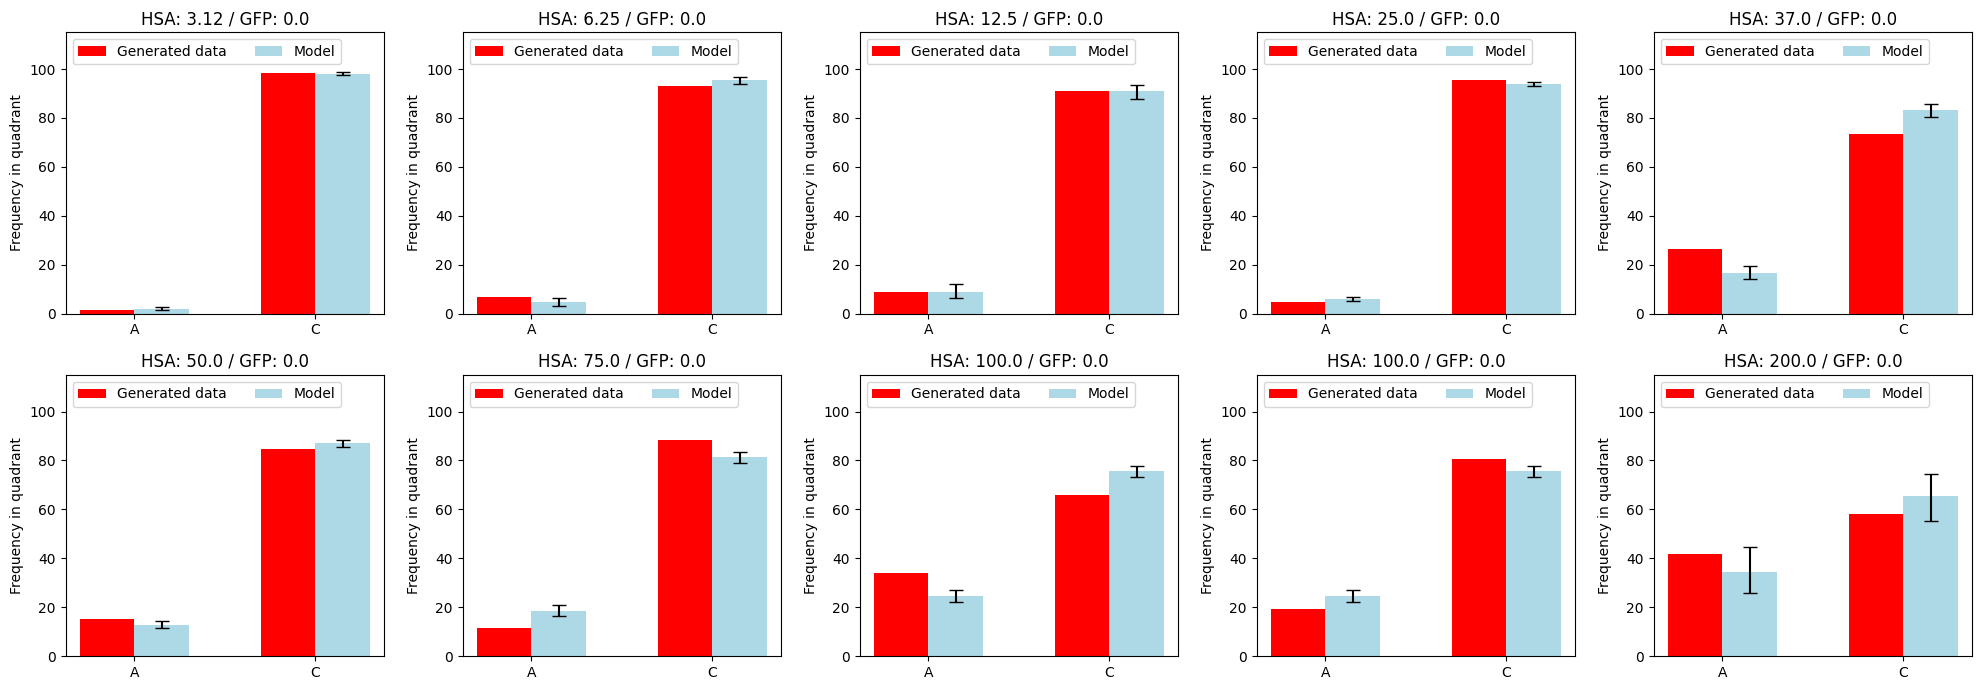

In [53]:
fig = plt.figure(figsize = (20, 7))

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    
    x = np.arange(2)
    width = 0.3
    
    offset = 0
    ax.bar(x + offset, data_gen[i,[0,2]], width, label = "Generated data", color = "red")
    offset = width
    ax.bar(x + offset, mean_HSA_single[i], width, label = "Model", color = "lightblue")
    ax.errorbar(x + offset, mean_HSA_single[i], yerr = ci_HSA_single[i], color = "black", capsize=5, ls='none')

    ax.set_ylabel('Frequency in quadrant')
    ax.set_title("HSA: " + str(dose_exp[0,i]) + " / " + "GFP: " + str(dose_exp[1,i]))
    ax.set_xticks((x + x + width*(2 - 1))/2, ["A", "C"])
    ax.legend(loc='upper left', ncols=3)
    
    ax.set_ylim(0, 115)

fig.tight_layout()
plt.show()

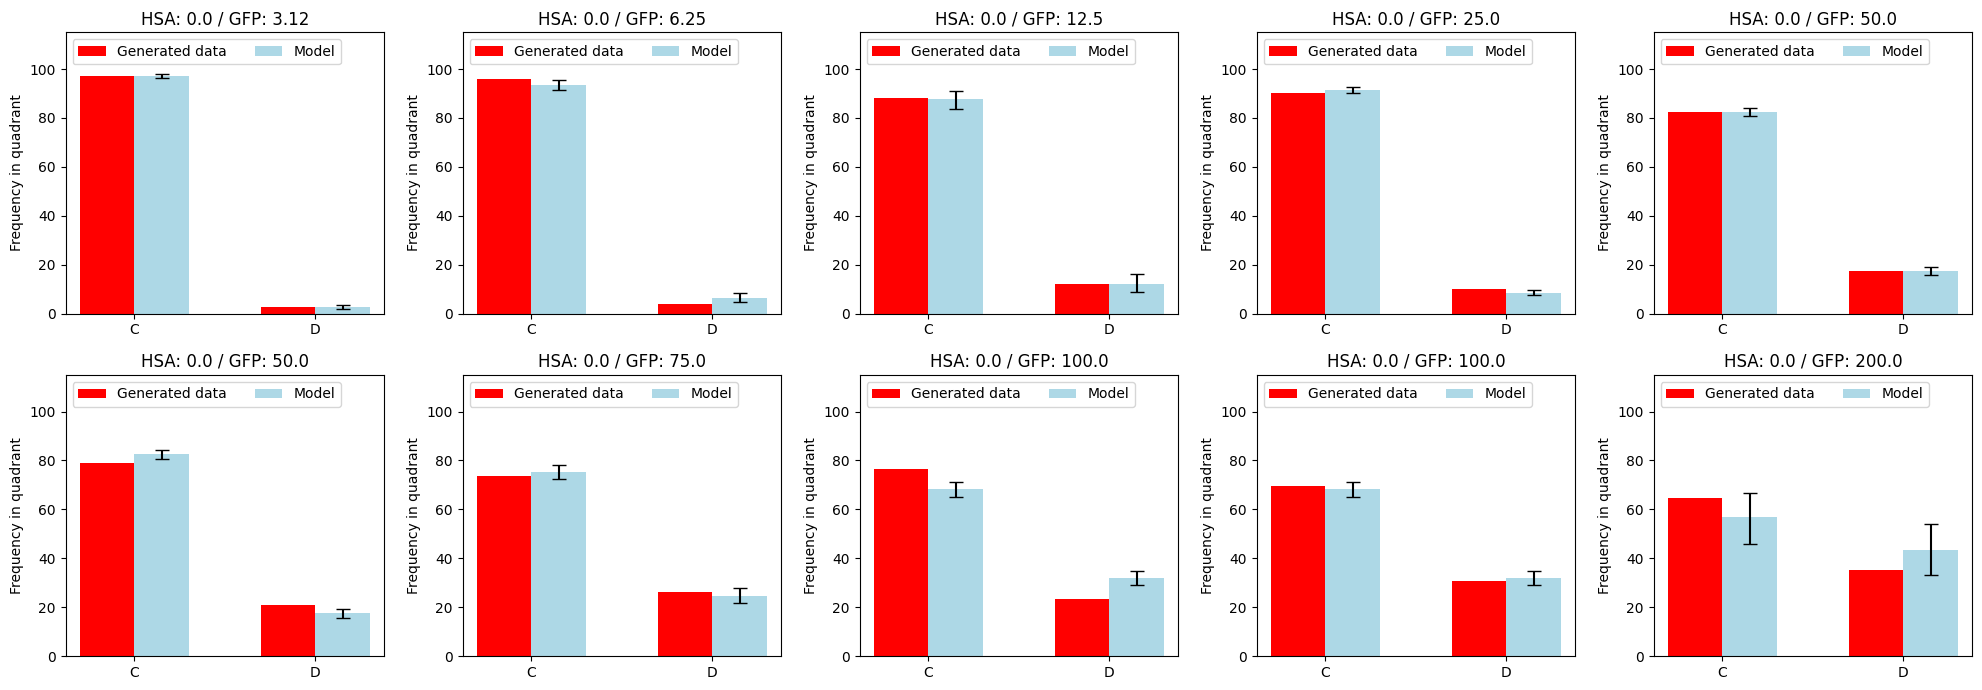

In [54]:
fig = plt.figure(figsize = (20, 7))

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    
    x = np.arange(2)
    width = 0.3
    
    offset = 0
    ax.bar(x + offset, data_gen[i+10,[2,3]], width, label = "Generated data", color = "red")
    offset = width
    ax.bar(x + offset, mean_GFP_single[i], width, label = "Model", color = "lightblue")
    ax.errorbar(x + offset, mean_GFP_single[i], yerr = ci_GFP_single[i], color = "black", capsize=5, ls='none')

    ax.set_ylabel('Frequency in quadrant')
    ax.set_title("HSA: " + str(dose_exp[0,i+10]) + " / " + "GFP: " + str(dose_exp[1,i+10]))
    ax.set_xticks((x + x + width*(2 - 1))/2, ["C", "D"])
    ax.legend(loc='upper left', ncols=3)
    
    ax.set_ylim(0, 115)

fig.tight_layout()
plt.show()

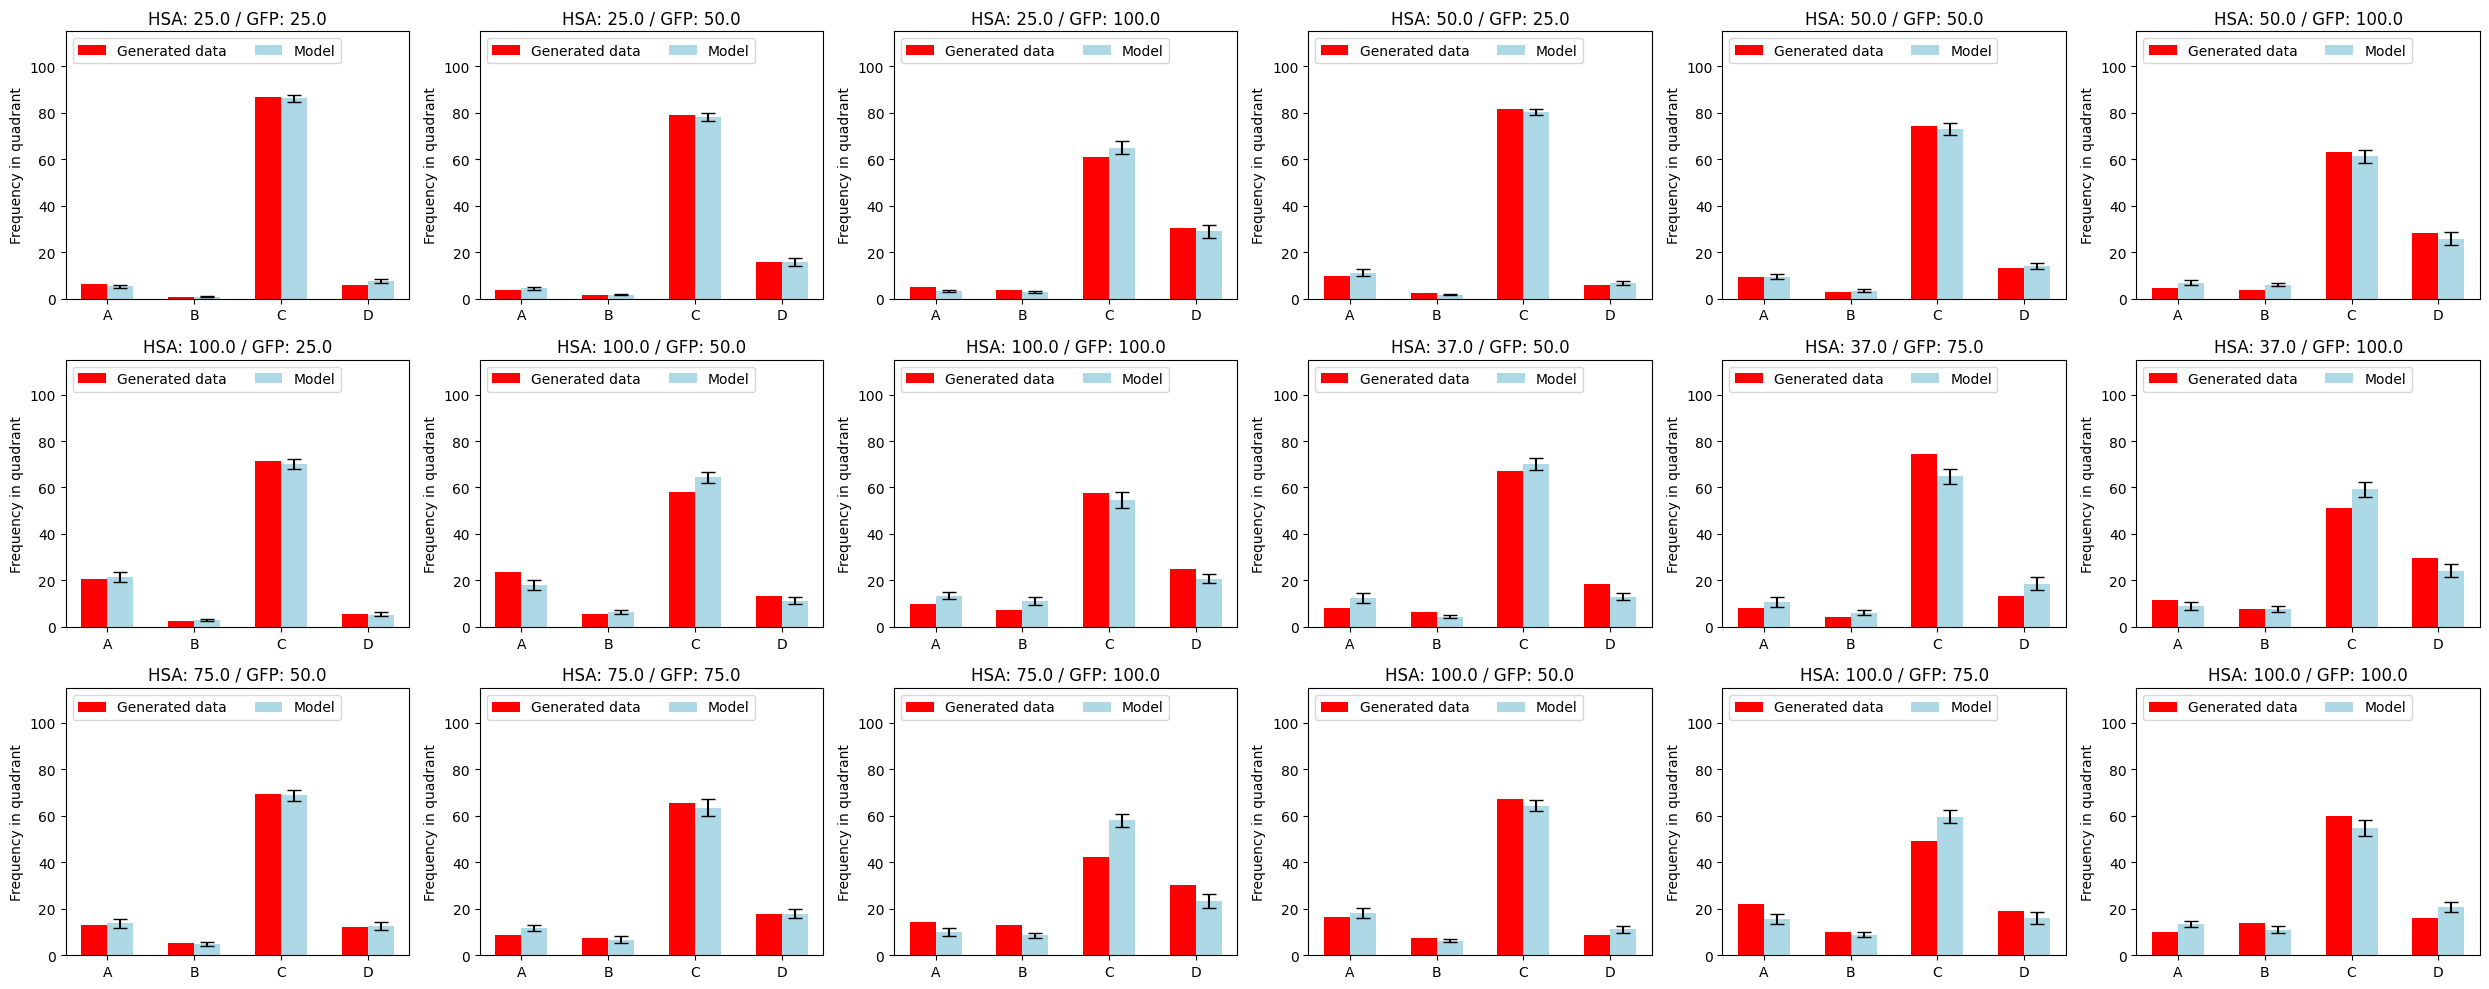

In [55]:
fig = plt.figure(figsize = (25, 10))

for i in range(18):
    ax = fig.add_subplot(3, 6, i + 1)
    
    x = np.arange(4)
    width = 0.3
    
    offset = 0
    ax.bar(x + offset, data_gen[i+20,], width, label = "Generated data", color = "red")
    offset = width
    ax.bar(x + offset, mean_co[i], width, label = "Model", color = "lightblue")
    ax.errorbar(x + offset, mean_co[i], yerr = ci_co[i], color = "black", capsize=5, ls='none')

    ax.set_ylabel('Frequency in quadrant')
    ax.set_title("HSA: " + str(dose_exp[0,i+20]) + " / " + "GFP: " + str(dose_exp[1,i+20]))
    ax.set_xticks((x + x + width*(2 - 1))/2, ["A", "B", "C", "D"])
    ax.legend(loc='upper left', ncols=3)
    
    ax.set_ylim(0, 115)

fig.tight_layout()
plt.show()

### 常微分方程式

ウイルスダイナミクスのような常微分方程式系によるシミュレーションと併せたベイズ推定手法を紹介する。

式（2.12）

$$
\begin{align}
\frac{d T \left( t \right)}{dt} &= L(t) - \beta T(t) V(t) \\
\frac{d I \left( t \right)}{dt} &= \beta T(t) V(t) - \delta I(t) \\
\frac{d V \left( t \right)}{dt} &= p I(t) - c V(t)
\end{align}
$$

について
$L(t) = \lambda - d T(t), \lambda = 0, d = 0.057, \beta = 8.61 \times 10^{-11}, \delta = 0.057 + 1.75, p = 3.26 \times 10^4, c = 1.93 + 0.039, T(0) = 6.46 \times 10^6, I(0) = 10^{-1}, V(0) = 5.0 \times 10^4$

In [533]:
## 擬似データの生成

## 計算する時刻の設定
Tmin = 0.0
Tmax = 20.0
step_size = 0.0001

## パラメータの設定
## lambda, d, beta, delta, p, c, T(0), I(0), V(0)
pars = np.array([0.0, 0.057, 8.61*np.power(10.0, -11.0),
                  0.057 + 1.75, 3.26*np.power(10.0, 4.0), 1.93 + 0.039,
                  6.46*np.power(10.0, 6.0), np.power(10.0, -1.0), 5.0*np.power(10.0, 4.0)])

## 傾き（微分）の定義
def ode_derives(var, t, plambda, d, beta, delta, p, c):
  
  ## var[0]: I(t), var[1]: V(t)
  dTdt = plambda - d * var[0] - beta * var[0] * var[2]
  dIdt = beta * var[0] * var[2] - delta * var[1]
  dVdt = p * var[1] - c * var[2]

  return [dTdt, dIdt, dVdt]

## パラメータを受け取ってodeint関数に渡す関数
def ODEs(parms):
  plambda = parms[0]
  d = parms[1]
  beta = parms[2]
  delta = parms[3]
  p = parms[4]
  c = parms[5]

  ## 計算のタイムステップ
  t_list = np.arange(Tmin, Tmax + step_size, step_size)
  ## 初期値 T(0), I(0), V(0)
  var_init = [parms[6], parms[7], parms[8]]
  ## 微分方程式の計算
  var_list = odeint(ode_derives, var_init, t_list, args = (plambda, d, beta, delta, p, c))

  return np.vstack([[t_list], var_list.T]).T

In [516]:
out = pd.DataFrame(ODEs(pars))
out = out.set_axis(["times", "TC", "IC", "VL"], axis = "columns")

In [517]:
(np.arange(2, 22, 2)/step_size) + 1

array([ 20001.,  40001.,  60001.,  80001., 100001., 120001., 140001.,
       160001., 180001., 200001.])

In [518]:
random.seed(1)
time_sample = list(range(int(2/step_size), int(22/step_size), int(2/step_size)))

data_temp = out.iloc[time_sample]

data_sample = pd.DataFrame()

for i in range(4):
    if i == 0:
        data_sample[data_temp.columns[i]] = data_temp.iloc[:,i]
    else:
        data_sample[data_temp.columns[i]] = np.exp(np.log(data_temp.iloc[:,i]) + np.random.normal(0, 1, data_temp.iloc[:,i].size))

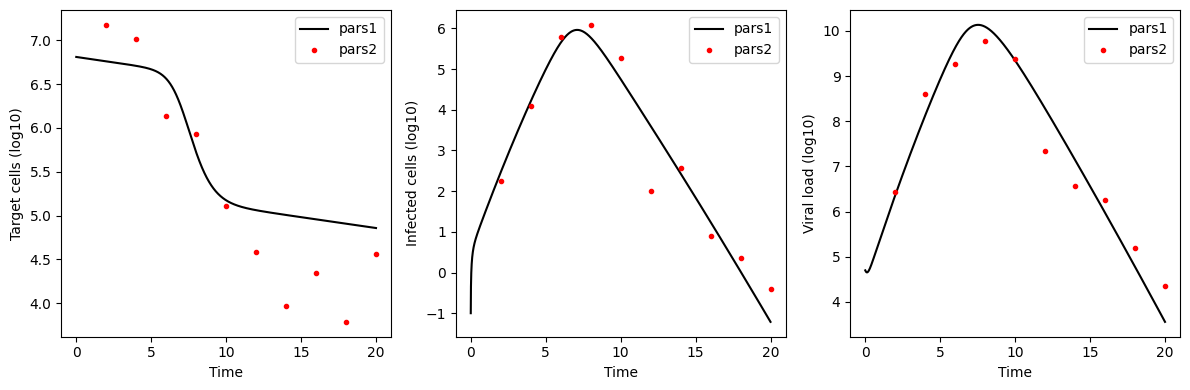

In [519]:
## プロットの準備
fig = plt.figure(figsize=(12,4))

## V(t)のプロット
ax1 = fig.add_subplot(1, 3, 1) ## 1行2列のプロットの１番目
ax1.plot(out.iloc[:,0], np.log10(out.iloc[:,1]), color = "black", label = "pars1") ## pars1でのT(t)の数値解のプロット
ax1.plot(data_sample.iloc[:,0], np.log10(data_sample.iloc[:,1]), color = "red", marker = ".", linestyle = "none", label = "pars2") ## pars2でのT(t)の数値解のプロット
ax1.set_xlabel("Time") ## x軸のラベル
ax1.set_ylabel("Target cells (log10)") ## y軸のラベル
ax1.legend() ## レジェンドの追加

## I(t)のプロット
ax2 = fig.add_subplot(1, 3, 2) ## 1行2列のプロットの１番目
ax2.plot(out.iloc[:,0], np.log10(out.iloc[:,2]), color = "black", label = "pars1") ## pars1でのT(t)の数値解のプロット
ax2.plot(data_sample.iloc[:,0], np.log10(data_sample.iloc[:,2]), color = "red", marker = ".", linestyle = "none", label = "pars2") ## pars2でのT(t)の数値解のプロット
ax2.set_xlabel("Time") ## x軸のラベル
ax2.set_ylabel("Infected cells (log10)") ## y軸のラベル
ax2.legend() ## レジェンドの追加

## V(t)のプロット
ax3 = fig.add_subplot(1, 3, 3) ## 1行2列のプロットの2番目
ax3.plot(out.iloc[:,0], np.log10(out.iloc[:,3]), color = "black", label = "pars1") ## pars1でのT(t)の数値解のプロット
ax3.plot(data_sample.iloc[:,0], np.log10(data_sample.iloc[:,3]), color = "red", marker = ".", linestyle = "none", label = "pars2") ## pars2でのT(t)の数値解のプロット
ax3.set_xlabel("Time") ## x軸のラベル
ax3.set_ylabel("Viral load (log10)") ## y軸のラベル
ax3.legend() ## レジェンドの追加

fig.tight_layout()
fig.show()

In [1012]:
model_stan_ode = '''
functions {
   vector virusdynamics(
      real t,
      vector y,
      real d,
      real beta,
      real delta,
      real p,
      real c
   ) {
      vector[3] dydt;
      dydt[1] = - d*y[1] - beta*y[1]*y[3];
      dydt[2] = beta*y[1]*y[3] - delta*y[2];
      dydt[3] = p*y[2] - c*y[3];
      return dydt;
   }
}

data {
   int<lower=1> num_data_points;
   int<lower=1> num_model_parameters;
   int<lower=1> num_initial_states;
   
   real time_start;
   
   array[num_data_points] real time_observed;
   array[num_data_points] real TC_observed;
   array[num_data_points] real IC_observed;
   array[num_data_points] real VL_observed;
}

parameters {
   // model parameters
   real<lower=log(1e-11), upper=log(1e-10)> beta;
   real<lower=log(1e+4), upper=log(1e+5)> p;
   real<lower=log(1e+4), upper=log(1e+5)> V0L;

   // standard deviation of error model
   real<lower=0, upper=100> sigma;
}

transformed parameters {
   real d = log(0.057);
   real delta = log(0.057 + 1.75);
   real c = log(1.93 + 0.039);
   real T0C = log(6.46*(10.0^6.0));
   real I0C = log(10.0^-1.0);
   
   vector[num_initial_states] Y0;
   
   Y0[1] = exp(T0C);
   Y0[2] = exp(I0C);
   Y0[3] = exp(V0L);
   
   array[num_data_points] vector<lower=0, upper=1e+20>[3] y_hat;
   
   // https://mc-stan.org/docs/functions-reference/functions-old-ode-solver.html
   y_hat = ode_rk45_tol(virusdynamics, Y0, time_start, time_observed, 1e-12, 1e-12, 10000000, exp(d), exp(beta), exp(delta), exp(p), exp(d));
   //y_hat = ode_rk45(virusdynamics, Y0, time_start, time_observed, exp(d), exp(beta), exp(delta), exp(p), exp(d));
}

model {
   
   beta ~ normal(log(5e-11), 1); //8.61*(10.0^-11.0)
   p ~ normal(log(5e+4), 1); //3.26*(10.0^4.0)
   V0L ~ normal(log(5e+4), 1); //5.0*(10.0^4.0)
   
   //beta ~ uniform(log(1e-11), log(1e-10)); //8.61*(10.0^-11.0)
   //p ~ uniform(log(1e+4), log(1e+5)); //3.26*(10.0^4.0)
   //V0L ~ uniform(log(1e+4), log(1e+5)); //5.0*(10.0^4.0)
   
   for (i in 1:num_data_points) {
       TC_observed[i] ~ lognormal(log(y_hat[i, 1]), sigma);
       IC_observed[i] ~ lognormal(log(y_hat[i, 2]), sigma);
       VL_observed[i] ~ lognormal(log(y_hat[i, 3]), sigma);
       
   }
   
   sigma ~ normal(0.5,0.5);
   
}
'''

一言メモ：

数値計算の安定化のために探索範囲を狭く設定しています。微分方程式のモデルによっては、パラメータの値によって数値計算の誤差が大きくなりすぎて計算が困難になる場合があります。  
実際には、パラメータの生物学的な意味を考えて探索範囲を限定したり、コード2-2で紹介した最小二乗法などでパラメータの値にあたりをつけてから、その周辺でサンプリングを行うのが良いです。  
または、数値計算誤差の許容範囲（tolerance）や数値計算を行う各ステップ間の間隔、ステップ数などを調整すると解決することもありますが、大きくなってしまう計算時間との兼ね合いです。

In [1013]:
pars

array([0.000e+00, 5.700e-02, 8.610e-11, 1.807e+00, 3.260e+04, 1.969e+00,
       6.460e+06, 1.000e-01, 5.000e+04])

In [1014]:
data_stan = {"num_data_points": data_sample.shape[0],
             "num_model_parameters": 5,
             "num_initial_states": 3,
             "time_start": 0,
             "time_observed": data_sample.times.tolist(),
             "TC_observed": data_sample.TC.tolist(),
             "IC_observed": data_sample.IC.tolist(),
             "VL_observed": data_sample.VL.tolist()}

In [1015]:
posterior = stan.build(model_stan_ode, data=data_stan, random_seed=1)

Building...

/home/iwanami/.cache/httpstan/4.11.0/models/yua3xuw5/model_yua3xuw5.cpp: In instantiation of ‘stan::scalar_type_t<T2> model_yua3xuw5_namespace::model_yua3xuw5::log_prob_impl(VecR&, VecI&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = false; VecR = Eigen::Matrix<double, -1, 1>; VecI = Eigen::Matrix<int, -1, 1>; stan::require_vector_like_t<VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::require_not_st_var<VecR>* <anonymous> = 0; stan::scalar_type_t<T2> = double; std::ostream = std::basic_ostream<char>]’:
/home/iwanami/.cache/httpstan/4.11.0/models/yua3xuw5/model_yua3xuw5.cpp:875:75:   required from ‘T_ model_yua3xuw5_namespace::model_yua3xuw5::log_prob(Eigen::Matrix<T_job_param, -1, 1>&, std::ostream*) const [with bool propto__ = false; bool jacobian__ = false; T_ = double; std::ostream = std::basic_ostream<char>]’
/home/iwanami/.local/lib/python3.8/site-packages/httpstan/include/stan/model/model_base_crtp.hpp:94:


Building: 19.7s, done.Messages from stanc:
Warning in '/tmp/httpstan_xu11sn7a/model_yua3xuw5.stan', line 59, column 11: The
    variable virusdynamics may not have been assigned a value before its use.
    in its declaration. These hard constraints are not recommended, for two
    reasons: (a) Except when there are logical or physical constraints, it is
    very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.


In [1016]:
pars[[2, 4, 8]]

array([8.61e-11, 3.26e+04, 5.00e+04])

In [1021]:
random.seed(5)

num_chain = 1
init_stan = []

for i in range(num_chain):
    init_stan.append({"beta": np.random.uniform(np.log(1e-11), np.log(1e-10), 1)[0],
                      "p": np.random.uniform(np.log(1e+4), np.log(1e+5), 1)[0],
                      "V0L": np.random.uniform(np.log(1e+4), np.log(1e+5), 1)[0],
                      "sigma": 0.1})

In [1022]:
init_stan

[{'beta': -25.233788443308462,
  'p': 11.216509425500035,
  'V0L': 11.004199682443808,
  'sigma': 0.1}]

In [1023]:
num_sample = 2000

fit = posterior.sample(num_chains=num_chain, num_samples=num_sample, init=init_stan, num_warmup = 1000)

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   3% (100/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  33% (1001/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  63% (1900/3000)
Sampling:  67% (2000/3000)
Sampling:  70% (2100/3000)
Sampling:  73% (2200/3000)
Sampling:  77% (2300/3000)
Sampling:  80% (2400/3000)
Sampling:  83% (2500/3000)Future exception was never retrieved
future: <Future finished exception=RuntimeError('write: Connection reset by peer [system:104]')>
concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/concurrent/futures/proc

In [1025]:
stan.model(fit)

TypeError: 'module' object is not callable

In [985]:
df_fit = fit.to_frame()

In [986]:
pars

array([0.000e+00, 5.700e-02, 8.610e-11, 1.807e+00, 3.260e+04, 1.969e+00,
       6.460e+06, 1.000e-01, 5.000e+04])

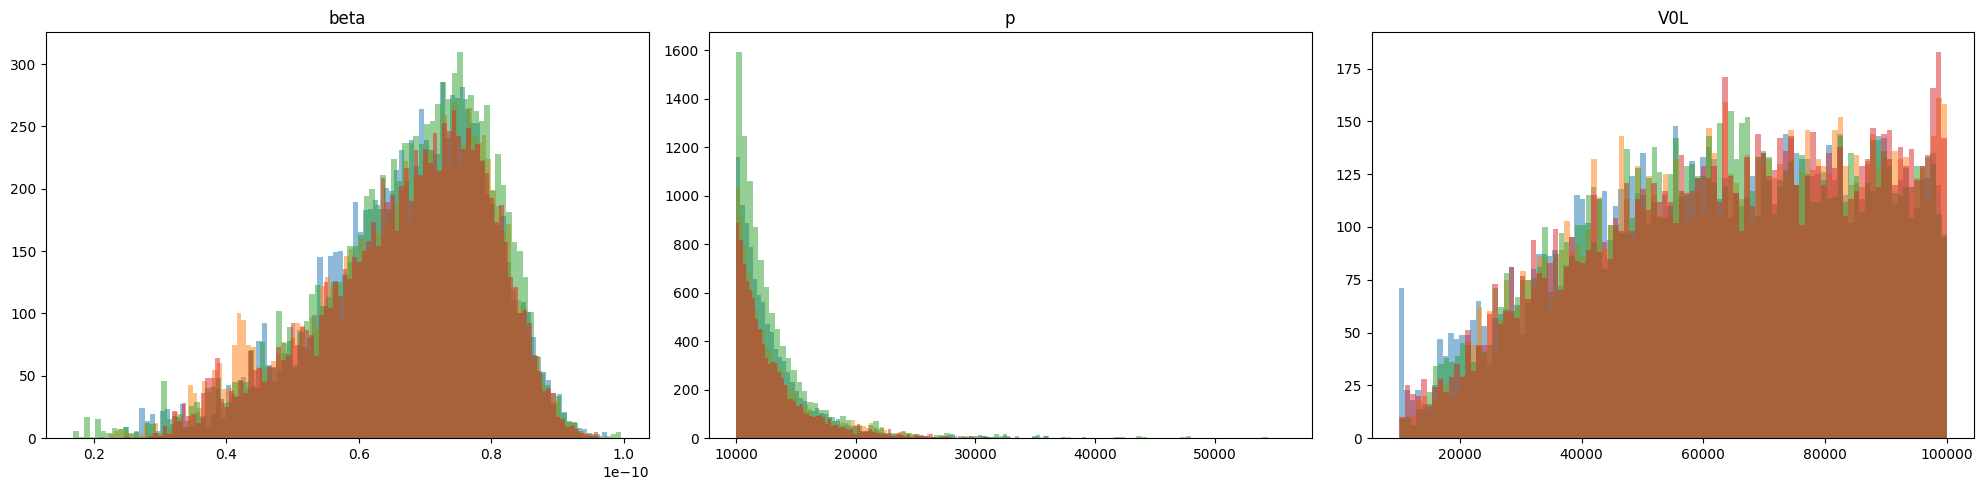

In [987]:
fig = plt.figure(figsize = (20, 5))

for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1)
    for j in range(4):
        ax.hist(np.exp(df_fit[fit.param_names[i]][(j*num_sample):(j+1)*num_sample]), bins = 100, alpha = 0.5)
        ax.set_title(fit.param_names[i])
    
fig.tight_layout()
plt.show()

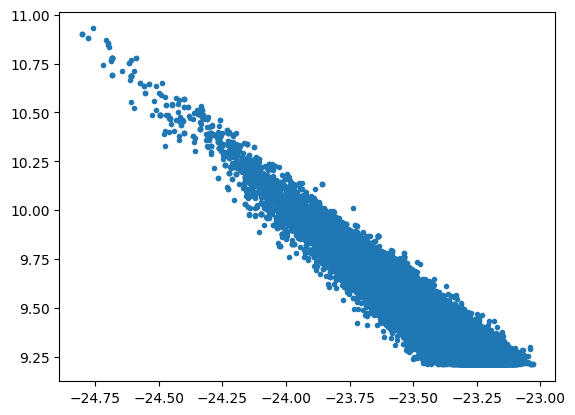

In [1010]:
plt.plot(df_fit["beta"], df_fit["p"], marker = ".", linestyle = "none")

In [1000]:
pars_mcmc = np.exp(df_fit.loc[random.sample(list(range(df_fit.shape[0])), 100), ["beta", "p", "V0L"]])

In [1001]:
tc_sample = []
ic_sample = []
vl_sample = []

for i in range(pars_mcmc.shape[0]):
    pars_temp = pars.copy()
    pars_temp[[2, 4, 8]] = pars_mcmc.iloc[i].tolist().copy()
    out = ODEs(pars_temp).T
    
    if (i < 3):
        print(i)
        print(out.T[1:10])
    
    tc_sample.append(out[1].tolist())
    ic_sample.append(out[2].tolist())
    vl_sample.append(out[3].tolist())


0
[[1.00000000e-04 6.45996318e+06 1.01266212e-01 3.17608230e+04]
 [2.00000000e-04 6.45992635e+06 1.02531942e-01 3.17547236e+04]
 [3.00000000e-04 6.45988953e+06 1.03797189e-01 3.17486273e+04]
 [4.00000000e-04 6.45985271e+06 1.05061954e-01 3.17425341e+04]
 [5.00000000e-04 6.45981589e+06 1.06326236e-01 3.17364440e+04]
 [6.00000000e-04 6.45977906e+06 1.07590037e-01 3.17303571e+04]
 [7.00000000e-04 6.45974224e+06 1.08853356e-01 3.17242732e+04]
 [8.00000000e-04 6.45970542e+06 1.10116193e-01 3.17181924e+04]
 [9.00000000e-04 6.45966860e+06 1.11378549e-01 3.17121148e+04]]
1
[[1.00000000e-04 6.45996318e+06 1.02994526e-01 5.89048304e+04]
 [2.00000000e-04 6.45992635e+06 1.05987907e-01 5.88933398e+04]
 [3.00000000e-04 6.45988953e+06 1.08980142e-01 5.88818546e+04]
 [4.00000000e-04 6.45985270e+06 1.11971232e-01 5.88703747e+04]
 [5.00000000e-04 6.45981588e+06 1.14961177e-01 5.88589001e+04]
 [6.00000000e-04 6.45977905e+06 1.17949978e-01 5.88474308e+04]
 [7.00000000e-04 6.45974223e+06 1.20937635e-01 5.8

In [1002]:
plot_tc_mean = np.mean(np.array(np.log10(tc_sample)), axis = 0)
plot_tc_min = np.percentile(np.array(tc_sample), 2.5, axis = 0)
plot_tc_max = np.percentile(np.array(tc_sample), 97.5, axis = 0)

plot_ic_mean = np.mean(np.array(ic_sample), axis = 0)
plot_ic_min = np.percentile(np.array(ic_sample), 2.5, axis = 0)
plot_ic_max = np.percentile(np.array(ic_sample), 97.5, axis = 0)

plot_vl_mean = np.mean(np.array(vl_sample), axis = 0)
plot_vl_min = np.percentile(np.array(vl_sample), 2.5, axis = 0)
plot_vl_max = np.percentile(np.array(vl_sample), 97.5, axis = 0)

In [1003]:
plot_time = ODEs(pars).T[0]

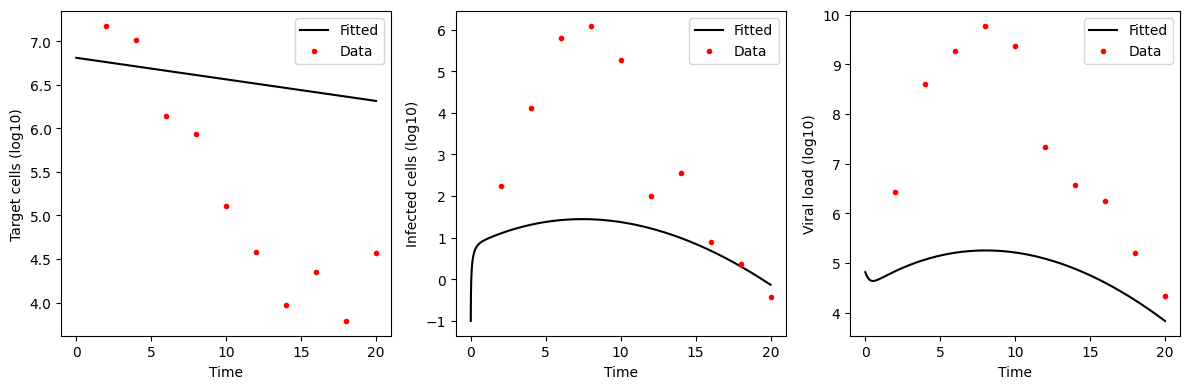

In [1004]:
## プロットの準備
fig = plt.figure(figsize=(12,4))

## V(t)のプロット
ax1 = fig.add_subplot(1, 3, 1) ## 1行2列のプロットの１番目
ax1.plot(plot_time, plot_tc_mean, color = "black", label = "Fitted") ## pars1でのT(t)の数値解のプロット
ax1.plot(data_sample.iloc[:,0], np.log10(data_sample.iloc[:,1]), color = "red", marker = ".", linestyle = "none", label = "Data") ## pars2でのT(t)の数値解のプロット
ax1.set_xlabel("Time") ## x軸のラベル
ax1.set_ylabel("Target cells (log10)") ## y軸のラベル
ax1.legend() ## レジェンドの追加

## I(t)のプロット
ax2 = fig.add_subplot(1, 3, 2) ## 1行2列のプロットの１番目
ax2.plot(plot_time, np.log10(plot_ic_mean), color = "black", label = "Fitted") ## pars1でのT(t)の数値解のプロット
ax2.plot(data_sample.iloc[:,0], np.log10(data_sample.iloc[:,2]), color = "red", marker = ".", linestyle = "none", label = "Data") ## pars2でのT(t)の数値解のプロット
ax2.set_xlabel("Time") ## x軸のラベル
ax2.set_ylabel("Infected cells (log10)") ## y軸のラベル
ax2.legend() ## レジェンドの追加

## V(t)のプロット
ax3 = fig.add_subplot(1, 3, 3) ## 1行2列のプロットの2番目
ax3.plot(plot_time, np.log10(plot_vl_mean), color = "black", label = "Fitted") ## pars1でのT(t)の数値解のプロット
ax3.plot(data_sample.iloc[:,0], np.log10(data_sample.iloc[:,3]), color = "red", marker = ".", linestyle = "none", label = "Data") ## pars2でのT(t)の数値解のプロット
ax3.set_xlabel("Time") ## x軸のラベル
ax3.set_ylabel("Viral load (log10)") ## y軸のラベル
ax3.legend() ## レジェンドの追加

fig.tight_layout()
fig.show()

In [408]:
np.log10(np.mean(np.array(tc_sample), axis = 0))

/tmp/ipykernel_2733390/2146264488.py:1: RuntimeWarning: invalid value encountered in log10
  np.log10(np.mean(np.array(tc_sample), axis = 0))


array([  6.81023252,   6.80817886,   6.8130819 , ..., -12.10274095,
       -12.10223839, -12.10173635])

In [416]:
list(range(200001))[(np.mean(np.array(tc_sample), axis = 0) > 0).tolist()]

TypeError: list indices must be integers or slices, not list

In [419]:
list(range(200001)).tolist()[[1,2]]

AttributeError: 'list' object has no attribute 'tolist'

In [428]:
np.exp(pars_mcmc)

parameters,beta,p,V0L
draws,,,
9712,7.612524e-12,9884.653442,135313.166273
22279,1.963435e-11,7161.661458,105948.238870
18066,1.435608e-11,11757.330764,126419.187763
35726,1.226659e-11,9609.078174,155455.906001
6034,7.938943e-12,14384.652845,88558.391418
...,...,...,...
22798,8.237627e-12,13423.939111,140295.328550
17948,8.818132e-12,7914.193043,125448.724498
22648,1.240116e-11,7620.427936,292133.228517


In [429]:
pars_mcmc

parameters,beta,p,V0L
draws,,,
9712,-25.601226,9.198739,11.815347
22279,-24.653741,8.876497,11.570706
18066,-24.966847,9.372232,11.747359
35726,-25.124142,9.170464,11.954117
6034,-25.559241,9.573917,11.391417
...,...,...,...
22798,-25.522309,9.504795,11.851505
17948,-25.454211,8.976413,11.739652
22648,-25.113231,8.938588,12.584965


In [424]:
[i for i, value in enumerate((np.mean(np.array(tc_sample), axis = 0) > 0).tolist()) if not value]

[132591,
 132592,
 132593,
 132594,
 132595,
 132596,
 132597,
 132598,
 132599,
 132600,
 132601,
 132602,
 132603,
 132604,
 132605,
 132606,
 132607,
 132608,
 132609,
 132610,
 132611,
 132612,
 132613,
 132614,
 132615,
 132616,
 132617,
 132618,
 132619,
 132620,
 132621,
 132622,
 132623,
 132624,
 132625,
 132626,
 132627,
 132628,
 132629,
 132630,
 132631,
 132632,
 132633,
 132634,
 132635,
 132636,
 132637,
 132638,
 132639,
 132640,
 132641,
 132642,
 132643,
 132644,
 132645,
 132646,
 132647,
 132648,
 132649,
 132650,
 132651,
 132652,
 132653,
 132654,
 132655,
 132656,
 132657,
 132658,
 132659,
 132660,
 132661,
 132662,
 132663,
 132664,
 132665,
 132666,
 132667,
 132668,
 132669,
 132670,
 132671,
 132672,
 132673,
 132674,
 132675,
 132676,
 132677,
 132678,
 132679,
 132680,
 132681,
 132682,
 132683,
 132684,
 132685,
 132686,
 132687,
 132688,
 132689,
 132690,
 132691,
 132692,
 132693,
 132694,
 132695,
 132696,
 132697,
 132698,
 132699,
 132700,
 132701,
 